In [4]:
# 📓 Notebook : Classification multimodale séquentielle CNN + Transformer

# 📦 Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D,
    TimeDistributed, Concatenate, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import json


2025-07-21 15:13:28.096177: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 15:13:28.108187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753103608.121706  802649 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753103608.125349  802649 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753103608.135915  802649 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:

# --- Dossiers (à adapter)
image_dir_le = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM'
image_dir_sub = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM'
json_dir = 'CDD-CESM/json_output'
excel_path = 'processed_metadata.csv'

# --- Fonction de chargement séquentiel des 8 images (chaque image 224x224x1)
def load_images_sequential(patient_id):
    paths = [
        f"{image_dir_le}/P{patient_id}_L_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_L_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_MLO.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_MLO.jpg",
    ]
    imgs = []
    for p in paths:
        img = Image.open(p).convert('L').resize((224, 224))
        arr = np.array(img) / 255.0
        arr = arr[..., np.newaxis]  # (224,224,1)
        imgs.append(arr)
    return np.stack(imgs, axis=0)  # (8,224,224,1)

# --- Chargement des métadonnées
meta_df = pd.read_csv(excel_path)
meta_df = meta_df.dropna(subset=['Patient_ID', 'Pathology Classification/ Follow up'])
meta_df['Patient_ID'] = meta_df['Patient_ID'].astype(str)

# --- Chargement textes JSON
texts = []
for pid in meta_df['Patient_ID']:
    path = os.path.join(json_dir, f"P{pid}.json")
    if os.path.exists(path):
        with open(path, encoding="utf-8") as f:
            try:
                d = json.load(f)
                flat_text = []
                for v in d.values():
                    flat_text.extend(map(str, v) if isinstance(v, list) else [str(v)])
                texts.append(" ".join(flat_text))
            except:
                texts.append("")
    else:
        texts.append("")


In [6]:

# --- Echantillonnage 80%
sampled_df = meta_df.sample(frac=0.8, random_state=42)
sampled_patient_ids = sampled_df['Patient_ID'].tolist()


In [7]:

# --- Chargement séquentiel des images + labels
images = []
valid_labels = []
valid_pids = []
skipped_image = 0

for pid, label in zip(sampled_df['Patient_ID'], sampled_df['Pathology Classification/ Follow up']):
    try:
        imgs_seq = load_images_sequential(pid)
        images.append(imgs_seq)
        valid_labels.append(label)
        valid_pids.append(pid)
    except Exception as e:
        print(f"Skip patient {pid} due to error: {e}")
        skipped_image += 1
        continue


Skip patient 69 due to error: [Errno 2] No such file or directory: 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P69_R_DM_CC.jpg'
Skip patient 196 due to error: [Errno 2] No such file or directory: 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P196_R_DM_CC.jpg'
Skip patient 47 due to error: [Errno 2] No such file or directory: 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P47_L_DM_CC.jpg'
Skip patient 294 due to error: [Errno 2] No such file or directory: 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P294_L_DM_CC.jpg'
Skip patient 86 due to error: [Errno 2] No such file or directory: 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P86_L_DM_MLO.jpg'
Skip patient 44 due to error: [Errno 2] No such file or directory: 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P44_R_DM_MLO.jpg'
Skip patient 186 due to error: [Errno 2] No such file or directory: 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low 

In [8]:

# --- Alignement des données
image_patient_ids = set(valid_pids)
text_patient_ids = set(sampled_patient_ids)
metadata_patient_ids = set(meta_df['Patient_ID'])
common_patient_ids = list(image_patient_ids & text_patient_ids & metadata_patient_ids)

image_dict = {pid: img for pid, img in zip(valid_pids, images) if pid in common_patient_ids}
label_dict = {pid: label for pid, label in zip(valid_pids, valid_labels) if pid in common_patient_ids}
text_dict = {pid: text for pid, text in zip(sampled_patient_ids, texts) if pid in common_patient_ids}
meta_dict = {pid: meta_df[meta_df['Patient_ID'] == pid].iloc[0] for pid in common_patient_ids}

images_filtered = np.array([image_dict[pid] for pid in common_patient_ids])  # shape (N, 8, 224, 224, 1)
labels_filtered = [label_dict[pid] for pid in common_patient_ids]
texts_filtered = [text_dict[pid] for pid in common_patient_ids]
meta_df_filtered = pd.DataFrame([meta_dict[pid] for pid in common_patient_ids])


In [9]:

# --- Textes vectorisés
vectorizer = TfidfVectorizer(max_features=1000)
text_features_filtered = vectorizer.fit_transform(texts_filtered).toarray()


In [10]:

# --- Encodage des métadonnées
numerical = meta_df_filtered.select_dtypes(include=['float', 'int']).columns.tolist()
categorical = meta_df_filtered.select_dtypes(include=['object']).drop(columns=['Patient_ID', 'Pathology Classification/ Follow up']).columns.tolist()

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

meta_num_filtered = scaler.fit_transform(meta_df_filtered[numerical])
meta_cat_filtered = encoder.fit_transform(meta_df_filtered[categorical])
meta_features_filtered = np.concatenate([meta_num_filtered, meta_cat_filtered], axis=1)

# --- Encodage des labels
valid_labels_encoded, label_names = pd.factorize(labels_filtered)
labels_cat = to_categorical(valid_labels_encoded)

# --- Poids de classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(valid_labels_encoded), y=valid_labels_encoded)
class_weight_dict = dict(enumerate(class_weights))


/tmp/ipykernel_802649/1470660569.py:13: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  valid_labels_encoded, label_names = pd.factorize(labels_filtered)


In [11]:

# --- Split train/test
X_img_temp, X_img_test, X_meta_temp, X_meta_test, X_txt_temp, X_txt_test, y_temp, y_test = train_test_split(
    images_filtered, meta_features_filtered, text_features_filtered, labels_cat,
    test_size=0.1, random_state=42)

X_img_train, X_img_val, X_meta_train, X_meta_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
    X_img_temp, X_meta_temp, X_txt_temp, y_temp,
    test_size=0.2, random_state=42)


In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Lambda, TimeDistributed, Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

# --- CNN préentraîné médical (RadImageNet = proche IRM/CT)
def create_radimagenet_encoder():
    base_model = DenseNet121(
        include_top=False,
        weights=None,  # on charge manuellement après
        input_shape=(224, 224, 3)
    )
    # Charger les poids RadImageNet
    base_model.load_weights("weights/RadImageNet-DenseNet121_notop.h5")

    base_model.trainable = False  # pour garder les features médicales

    inputs = Input(shape=(224, 224, 1), name="img_input_gray")
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    return Model(inputs, x, name="radimagenet_densenet_encoder")



In [13]:

# --- TransformerBlock déjà défini plus tôt
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [14]:

# --- Construction du modèle multimodal complet
# Inputs
img_seq_input = Input(shape=(8, 224, 224, 1), name='img_seq_input')
meta_input = Input(shape=(meta_features_filtered.shape[1],), name='meta_input')
text_input = Input(shape=(text_features_filtered.shape[1],), name='text_input')

# CNN encoder partagé (RadImageNet)
cnn_encoder = create_radimagenet_encoder()

# Traitement de la séquence d'images
x_img_seq = TimeDistributed(cnn_encoder)(img_seq_input)  # (batch, 8, 64)

# Transformer
x_img_seq = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x_img_seq)  # (batch, 8, 64)
x_img_seq = tf.keras.layers.GlobalAveragePooling1D()(x_img_seq)

# Métadonnées et texte
x_meta = Dense(64, activation='relu')(meta_input)
x_text = Dense(64, activation='relu')(text_input)

# Fusion multimodale
x = Concatenate()([x_img_seq, x_meta, x_text])
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(label_names), activation='softmax')(x)

model = Model(inputs=[img_seq_input, meta_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


2025-07-21 15:17:48.111171: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_seq_input       │ (None, 8, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 64)     │  7,103,104 │ img_seq_input[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 8, 64)     │     83,200 │ time_distributed… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 381)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 272)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     24,448 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     17,472 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_3[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        195 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,261,379 (27.70 MB)

 Trainable params: 223,875 (874.51 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [15]:

# --- Entraînement
history = model.fit(
    [X_img_train, X_meta_train, X_txt_train], y_train,
    validation_data=([X_img_val, X_meta_val, X_txt_val], y_val),
    epochs=30,
    batch_size=16,
    class_weight=class_weight_dict
)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 117s 9s/step - accuracy: 0.3570 - loss: 1.2258 - val_accuracy: 0.4000 - val_loss: 1.0991
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step - accuracy: 0.3345 - loss: 1.1836 - val_accuracy: 0.3714 - val_loss: 1.0889
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.3157 - loss: 1.1432 - val_accuracy: 0.3143 - val_loss: 1.1009
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.3014 - loss: 1.1082 - val_accuracy: 0.3714 - val_loss: 1.0871
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - accuracy: 0.3479 - loss: 1.1172 - val_accuracy: 0.3714 - val_loss: 1.0807
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.3126 - loss: 1.1299 - val_accuracy: 0.3429 - val_loss: 1.1081
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.4043 - loss: 1.0486 - val_accuracy: 0.3429 - val_loss: 1.0918
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - accuracy: 0.3507 - loss: 1.0753 - val_accuracy: 0.4286 - val_loss: 1.0833
Epoch 9

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
              precision    recall  f1-score   support

   Malignant       0.57      0.67      0.62         6
      Normal       0.71      0.45      0.56        11
      Benign       0.17      0.33      0.22         3

    accuracy                           0.50        20
   macro avg       0.48      0.48      0.46        20
weighted avg       0.59      0.50      0.52        20

F1-score (weighted): 0.5235042735042735
Accuracy: 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5000 - loss: 1.7492
Test accuracy: 0.5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


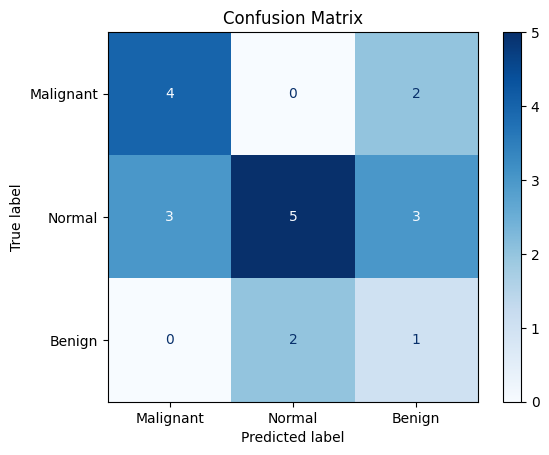

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
ROC AUC Score: 0.6087


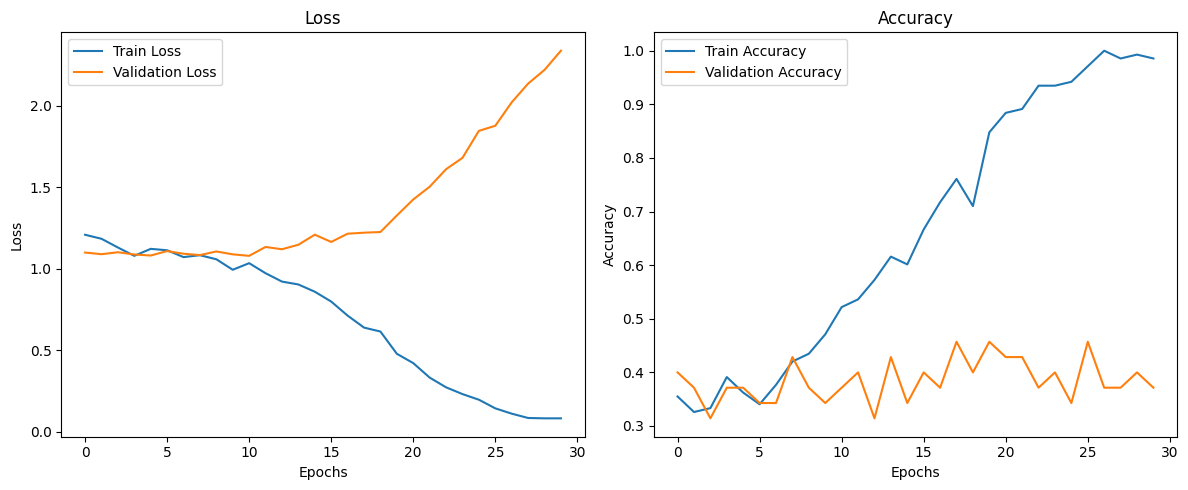

In [16]:

# --- Évaluation sur test
# Prédictions
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_proba = model.predict([X_img_test, X_meta_test, X_txt_test])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print(classification_report(y_true, y_pred, target_names=label_names))
print("F1-score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_true, y_pred))

test_loss, test_acc = model.evaluate([X_img_test, X_meta_test, X_txt_test], y_test)
print(f"Test accuracy: {test_acc:.4f}")

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict([X_img_test, X_meta_test, X_txt_test])
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
import matplotlib.pyplot as plt
plt.title('Confusion Matrix')
plt.show()

# Roc- AUC

from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict([X_img_test, X_meta_test, X_txt_test])
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")


# loss and accuracy curves

import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)


In [20]:
# 📥 Sauvegarde des métriques dans un CSV
import csv
from sklearn.metrics import precision_score, recall_score
from datetime import datetime
import os

# Calcul des métriques
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

# Heure actuelle
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Nom du fichier script / notebook (si exécuté depuis un fichier)
try:
    filename = os.path.basename(__file__)
except NameError:
    # Si exécuté dans un notebook Jupyter
    filename = "notebook"

# Chemin du CSV
metrics_file = "model_metrics_log.csv"

# Vérifie si le fichier existe déjà
file_exists = os.path.isfile(metrics_file)

# Sauvegarde en ajoutant une ligne
with open(metrics_file, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        # Écrire l'en-tête si le fichier est nouveau
        writer.writerow(["timestamp", "filename", "precision", "recall", "f1_score", "accuracy", "roc_auc"])
    writer.writerow([timestamp, filename, precision, recall, f1, accuracy, roc_auc])
